In [1]:
# https://platform.openai.com/docs/guides/vision
from openai import OpenAI
import base64
import requests
import os
from PIL import Image
from pillow_heif import register_heif_opener
import torch
from transformers.image_utils import ImageFeatureExtractionMixin

import open3d as o3d
import numpy as np
import pyrealsense2 as rs
import matplotlib.pyplot as plt
import RealSense as real

# Initialize RS435i connection
rsc = real.RealSense()
rsc.initConnection()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Import OWL-ViT
# from LANGrasp: https://huggingface.co/docs/transformers/model_doc/owlvit
from transformers import OwlViTProcessor, OwlViTForObjectDetection
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [3]:
# Import Segment Anything
from segment_anything import build_sam, SamPredictor 
import cv2
import copy

predictor = SamPredictor(build_sam(checkpoint="/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"))

In [4]:
# Helper Functions

# plot predictions
# https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb
SCORE_THRESHOLD = 0.01

def get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    pboxes = []
    uboxes = []
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      pboxes.append((pbox, text_queries[label]))
      uboxes.append((box, text_queries[label]))
    return pboxes, uboxes

def plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()
    
    idx = 0
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      print(pbox)
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]} ({idx}): {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
      idx += 1

def show_mask(mask, ax, random_color=False):
    '''
    @param mask bool image mask
    @param ax matplotlib fig
    '''
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def encode_image(image_path):
    with open(f"{image_path}", "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
def displayWorld(worldPCD):
    coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    geometry = [coordFrame]
    geometry.append(worldPCD)
    o3d.visualization.draw_geometries(geometry)

In [5]:
def retrieve_mask_from_image_crop(box, full_o3d_image):
    '''
    @param box 2d bounding box in form [x0, y0, x1, y1]
    @param full_o3d_image Open3D RGBD Image
    '''
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])
    # y_min = int(box[0])
    # x_min = int(box[1])
    # y_max = int(box[2])
    # x_max = int(box[3])
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    bbox = x_min, y_min, x_max, y_max

    # mask out bounding box in img
    depth_image = np.asarray(full_o3d_image.depth)
    # depth_values = depth_image[x_min:x_max, y_min:y_max]
    depth_values = depth_image[y_min:y_max, x_min:x_max]
    depth_o3d = o3d.geometry.Image((depth_values).astype(np.uint8))
    rgb_image    = np.asarray(full_o3d_image.color)
    # rgb_values = np.asarray(rgbdImage.color)[x_min:x_max, y_min:y_max]
    rgb_values = np.asarray(full_o3d_image.color)[y_min:y_max, x_min:x_max]
    rgb_o3d = o3d.geometry.Image((rgb_values).astype(np.uint8))

    cropped_o3d_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d)

    # Also, assuming x_min, x_max, y_min, y_max define your region of interest (ROI)

    # Create masks for the region of interest
    roi_mask_rgb = np.zeros_like(rgb_image, dtype=bool)
    # roi_mask_rgb[x_min:x_max, y_min:y_max, :] = True
    roi_mask_rgb[y_min:y_max, x_min:x_max, :] = True

    roi_mask_depth = np.zeros_like(depth_image, dtype=bool)
    # roi_mask_depth[x_min:x_max, y_min:y_max] = True
    roi_mask_depth[y_min:y_max, x_min:x_max] = True

    rgb_m_array = rgb_image
    depth_m_array = depth_image
    # Apply the masks to set values outside the ROI to 0
    rgb_m_array[~roi_mask_rgb] = 255
    depth_m_array[~roi_mask_depth] = 0
    depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
    rgb_m = o3d.geometry.Image((rgb_m_array).astype(np.uint8))
    
    rgbd_m_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_m, depth_m)
    
    return depth_m, rgb_m, rgbd_m_image

In [6]:
def create_depth_mask_from_mask(mask, orig_depth):
    '''
    @param mask np.array of item mask
    @param orig_depth Open3D Image
    '''
    # depth_m_array = np.zeros_like(np.asarray(orig_depth))
    depth_m_array = np.asarray(orig_depth)
    depth_m_array[~mask] = 0
    depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
    return depth_m

In [7]:
def crop_and_denoise_pcd(depth_m, orig_pcd, NB=50):
    '''
    @param depth_m Open3D Image, single channel depth image
    @param orig_pcd uncropped Open3D point cloud 
    '''
    ###
    # This is the magic line
    # find the depth mask from the OWL ViT bounding box
    # reassign the orig rgbdImage
    # then recreate the pcd
    ###
    orig_pcd.depth = depth_m
    # et voila
    cpcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        orig_pcd,
        # rgbd_m_image,
        rsc.pinholeInstrinsics,
        project_valid_depth_only=True,
        extrinsic=rsc.extrinsics
    )

    # denoise pcd
    cl, ind = cpcd.remove_statistical_outlier(nb_neighbors=NB, std_ratio=0.01)
    inlier_cloud = cpcd.select_by_index(ind)
    # display_inlier_outlier(saved_pcd, ind)
    # displayWorld(inlier_cloud)

    mc = inlier_cloud.compute_mean_and_covariance()
    return inlier_cloud, mc

[975.6277322769165, 130.25594472885132, 1111.3304281234741, 256.58519983291626]
[439.91357803344727, 272.95331060886383, 587.4913597106934, 421.37159764766693]
[856.0146284103394, 298.9610552787781, 988.8633012771606, 420.60301065444946]
[540.6884956359863, 360.081045627594, 714.1776847839355, 532.4455904960632]
[745.4515886306763, 398.94956946372986, 880.9551191329956, 530.2089178562164]
[541.5651512145996, 341.33549451828003, 771.6883277893066, 597.1323609352112]
[618.4502553939819, 442.3848867416382, 764.0331125259399, 601.0939836502075]
[170.2571201324463, 584.9007904529572, 327.544469833374, 711.5394866466522]
[487.7619171142578, 546.978120803833, 669.4738006591797, 699.3102550506592]


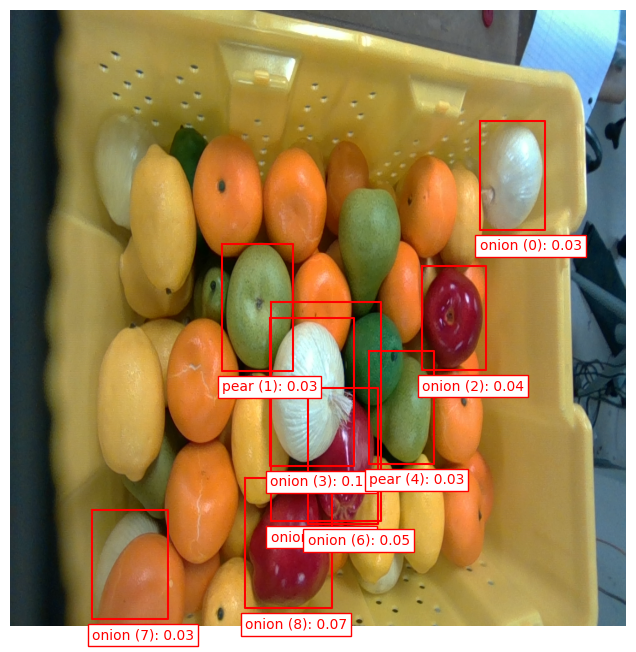

In [10]:
# take RealSense picture and run OWL-ViT inference
pcd,rgbdImage = rsc.getPCD()
img_tensor = torch.tensor(np.asarray(rgbdImage.color), dtype=torch.float32)
img = np.asarray(rgbdImage.color)

# run image through OWL-ViT
texts = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
# texts = [ "a photo of red cube", "a photo of a blue cube", "a photo of a yellow cube"]
# texts = ["apple", "lemon", "lime", "pear"]
inputs = processor(texts, images=img_tensor, padding=True, return_tensors="pt")
outputs = model(**inputs)
target_sizes = torch.Tensor([img.shape[:2][::-1]])

# Get prediction logits
def get_preds(outputs):
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()
    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    # boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    pboxes = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)[0]['boxes']
    return scores, labels, boxes, pboxes

scores, labels, boxes, pboxes = get_preds(outputs)
input_image = np.asarray(img).astype(np.float32) / 255.0
text_queries = ["apple", "lemon", "lime", "pear", "onion"]
# text_queries = ["r", "b", "y"]
# text_queries = ["apple", "lemon", "lime", "pear"]
THRESHOLD = 0.025
plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)
bboxes, uboxes = get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)


In [11]:
pcd,rgbdImage = rsc.getPCD()
# index corresponds to (<num>) following label name of bounding boxes in above annotated image
index = 3
dm, rm, imgm = retrieve_mask_from_image_crop(bboxes[index][0], rgbdImage)
cpcd, mc = crop_and_denoise_pcd(dm, rgbdImage)
grasp_pose = [mc[0][1], -mc[0][0], mc[0][2]]
print(grasp_pose)
displayWorld(cpcd)

[0.04667966860259789, 0.0076749092902097015, 0.324438464754618]


In [ ]:
[0.08676600443387782, -0.02026244112525203, 0.3158801013884449]

In [19]:
# get masks from bounding boxes
pcd,rgbdImage = rsc.getPCD()

dims = target_sizes[0].numpy().astype(dtype=int)
boxes = np.array([np.array(i[0]) for i in bboxes])
H, W = dims[1], dims[0]
boxes = torch.tensor(boxes)
labels = np.array([i[1] for i in uboxes])
size = [H, W]
pred_dict = {
    # "boxes": normalized_boxes,
    "boxes": boxes,
    "size": [size[1], size[0]], # H, W
    "labels": labels
}

rgb_array = (np.array(rgbdImage.color))
# don't know why colors aren't correct without this prior manual rotation
cv2_array = rgb_array[:, :, ::-1].copy()
image = cv2.cvtColor(cv2_array, cv2.COLOR_RGB2BGR)


In [20]:
# TODO: figure out why this takes so long
# ok I immediately see now that this calculates the image embeddings...
predictor.set_image(image)

In [21]:
boxes_copy = copy.deepcopy(boxes)
transformed_boxes = predictor.transform.apply_boxes_torch(boxes_copy, img.shape[:2][::-1])

masks, _, _ = predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = transformed_boxes,
    multimask_output = False,
)

(-0.5, 1279.5, 719.5, -0.5)

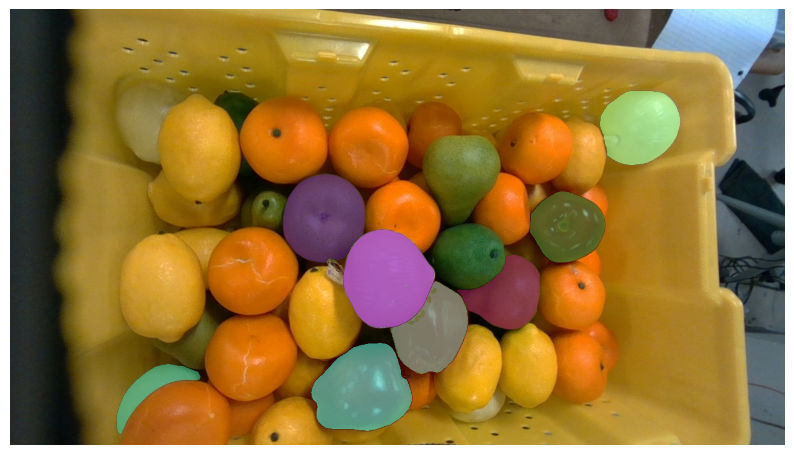

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.axis('off')

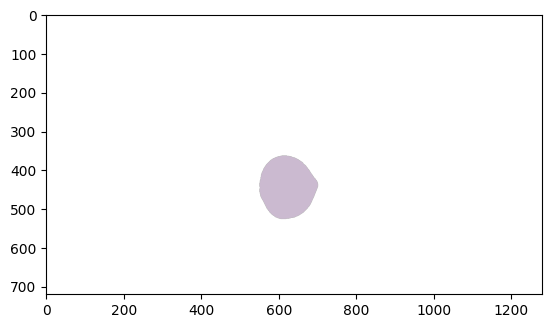

In [23]:
show_mask(masks[3].cpu().numpy(), plt.gca(), random_color=True)

In [24]:
pcd,rgbdImage = rsc.getPCD()
index = 3
mdm = create_depth_mask_from_mask(np.array(masks[index][0]), rgbdImage.depth)
mcpcd, mmc = crop_and_denoise_pcd(mdm, rgbdImage, NB=20)
m_grasp_pose = [mmc[0][1], -mmc[0][0], mmc[0][2]]
print(m_grasp_pose)
displayWorld(mcpcd)

[0.04286790955876129, 0.006318529672496234, 0.29891944251746955]
